In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Google Drive Mount

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/My Drive/DA_1st_proj/with_score

/content/gdrive/My Drive/DA_1st_proj/with_score


In [7]:
%ls

'콰이어트 플레이스2.csv'   더넌.csv     곤지암.csv         검은사제들.csv
 47m.csv                   변신.csv     컨저링.csv         Untitled0.ipynb
 어스.csv                  애나벨.csv   이스케이프룸.csv


# 네이버 영화 리뷰 데이터








전처리

In [13]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f5211a239d0>)

In [45]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [46]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [47]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [48]:
print('테스트용 리뷰 개수 :',len(test_data)) 

테스트용 리뷰 개수 : 50000


In [49]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [50]:
train_data = pd.concat([train_data, test_data])

In [51]:
train_data['document'].nunique(), train_data['label'].nunique()

(194543, 2)

In [52]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [53]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 194544


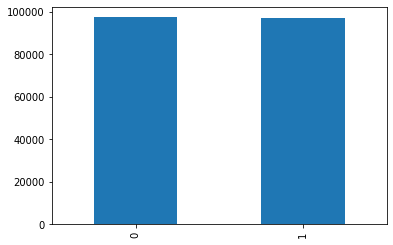

In [54]:
train_data['label'].value_counts().plot(kind = 'bar')

In [55]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97375
1      1  97169


In [56]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [57]:
train_data = train_data.dropna(how = 'any')

In [58]:
print(len(train_data))

194543


In [59]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [60]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id             0
document    1025
label          0
dtype: int64


In [61]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

193518


토큰화

In [62]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [63]:
#Okt는 KoNLPy에서 제공하는 형태소 분석기
okt = Okt()

In [64]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [65]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


정수 인코딩 -> 각 단어에 고유 정수 부여


빈도수가 높을수록 앞번호 부여

In [66]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [67]:
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '재밌다': 12, '적': 13, '만': 14, '진짜': 15, '같다': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '평점': 25, '것': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '인': 31, '안': 32, '생각': 33, '못': 34, '스토리': 35, '왜': 36, '드라마': 37, '게': 38, '사람': 39, '감동': 40, '보고': 41, '이렇다': 42, '고': 43, '말': 44, '더': 45, '아깝다': 46, '때': 47, '배우': 48, 'ㅋㅋ': 49, '감독': 50, '아': 51, '거': 52, '그냥': 53, '재미있다': 54, '요': 55, '재미': 56, '내용': 57, '시간': 58, '까지': 59, '중': 60, '주다': 61, '뭐': 62, '자다': 63, '하고': 64, '지루하다': 65, '재미없다': 66, '수': 67, '네': 68, '쓰레기': 69, '가다': 70, '들다': 71, '모르다': 72, '그렇다': 73, '싶다': 74, '지': 75, '사랑': 76, '작품': 77, '알다': 78, '다시': 79, '하나': 80, '볼': 81, '마지막': 82, '이건': 83, '저': 84, '정도': 85, '오다': 86, 'ㅠㅠ': 87, '완전': 88, 'ㅋ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '주인공': 94, '액션': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '하': 101, '최악': 

In [68]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 49645
등장 빈도가 2번 이하인 희귀 단어의 수: 27461
단어 집합에서 희귀 단어의 비율: 55.314734615771975
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5766271342202085


In [69]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22185


In [71]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [72]:
print(X_train[:3])

[[51, 450, 15, 250, 643], [962, 462, 41, 594, 1, 216, 1359, 24, 945, 676, 19], [393, 2604, 2245, 5932, 2, 222, 9]]


In [73]:
y_train = np.array(train_data['label'])

In [74]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [75]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

193224
193224


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.869333002111539


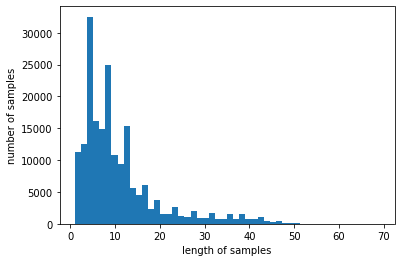

In [76]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [77]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


In [78]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.25795967374653


In [79]:
X_train = pad_sequences(X_train, maxlen = max_len)

LSTM

In [80]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [81]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [82]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [83]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2577/2577 [==============================] - 243s 92ms/step - loss: 0.3796 - acc: 0.8293 - val_loss: 0.3697 - val_acc: 0.8355

Epoch 00001: val_acc improved from -inf to 0.83550, saving model to best_model.h5
Epoch 2/15
2577/2577 [==============================] - 238s 92ms/step - loss: 0.3215 - acc: 0.8616 - val_loss: 0.3359 - val_acc: 0.8541

Epoch 00002: val_acc improved from 0.83550 to 0.85413, saving model to best_model.h5
Epoch 3/15
2577/2577 [==============================] - 236s 91ms/step - loss: 0.2982 - acc: 0.8749 - val_loss: 0.3279 - val_acc: 0.8571

Epoch 00003: val_acc improved from 0.85413 to 0.85711, saving model to best_model.h5
Epoch 4/15
2577/2577 [==============================] - 239s 93ms/step - loss: 0.2800 - acc: 0.8841 - val_loss: 0.3279 - val_acc: 0.8587

Epoch 00004: val_acc improved from 0.85711 to 0.85869, saving model to best_model.h5
Epoch 5/15
2577/2577 [==============================] - 238s 92ms/step - loss: 0.2651 - acc: 0.8916 - val_loss:

In [86]:
loaded_model = load_model('best_model.h5')

# test data 전처리


In [84]:
%ls

'콰이어트 플레이스2.csv'   더넌.csv     컨저링.csv         ratings_train.txt
 47m.csv                   변신.csv     이스케이프룸.csv   Untitled0.ipynb
 best_model.h5             애나벨.csv   검은사제들.csv
 어스.csv                  곤지암.csv   ratings_test.txt


In [85]:
movie_list = ['콰이어트 플레이스2','더넌','곤지암','검은사제들','47m','변신','컨저링','어스','애나벨','이스케이프룸']

In [157]:
test_data = pd.read_csv('검은사제들.csv')
test_data.head()

,review,score
0,이런 한국에서 거의 사용하지 않는 소재를 가지고 영화를 만들었다는 것 만으로도 난...,8
1,안티들 꺼져. 시사회 봤는데 최근 한국영화 중 가장 특이하고 긴장감 넘치는 영화다....,10
2,관람객두 배우의 연기에 완전 놀랐다. 몰입이라는 단어는 이럴 때 쓰는 것,10
3,시사회에서 보고왔다. 강동원 영상화보집일 줄 알았는데 내용까지 재밌어서 놀람,10
4,"몰입도 괜찮았으며, 박소담 연기가 대단하네요 ~ ㅂㅍㅅ 초치지말고 된장 발라버리기전...",9


In [158]:
test_data = test_data[(test_data['score']>=9)| (test_data['score']<=4)]

In [159]:
test_data['label'] = np.where(test_data['score']>=9, 1, 0)

In [160]:
test_data.head()

,review,score,label
1,안티들 꺼져. 시사회 봤는데 최근 한국영화 중 가장 특이하고 긴장감 넘치는 영화다....,10,1
2,관람객두 배우의 연기에 완전 놀랐다. 몰입이라는 단어는 이럴 때 쓰는 것,10,1
3,시사회에서 보고왔다. 강동원 영상화보집일 줄 알았는데 내용까지 재밌어서 놀람,10,1
4,"몰입도 괜찮았으며, 박소담 연기가 대단하네요 ~ ㅂㅍㅅ 초치지말고 된장 발라버리기전...",9,1
5,관람객우리나라에서 이런 새로움에 강동원인데 안보면 안대지,10,1


In [161]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 14895


In [162]:
X_test = []
for sentence in test_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [163]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_len)

y_test = np.array(test_data['label'])

In [164]:
test_data['pred'] = 1000
test_data['prob'] = 1000.00

In [165]:
for i in test_data.index:
  new_sentence = test_data['review'][i]
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측

  if(score > 0.5):
    prob = score * 100
    pred = 1
  else:
    prob = (1 - score) * 100
    pred = 0
  test_data['prob'][i] = prob
  test_data['pred'][i] = pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [166]:
test_data.head(20)

,review,score,label,pred,prob
1,안티들 꺼져 시사회 봤는데 최근 한국영화 중 가장 특이하고 긴장감 넘치는 영화다 어...,10,1,1,94.269288
2,관람객두 배우의 연기에 완전 놀랐다 몰입이라는 단어는 이럴 때 쓰는 것,10,1,1,82.698917
3,시사회에서 보고왔다 강동원 영상화보집일 줄 알았는데 내용까지 재밌어서 놀람,10,1,1,88.799405
4,몰입도 괜찮았으며 박소담 연기가 대단하네요 ㅂㅍㅅ 초치지말고 된장 발라버리기전에 ...,9,1,1,86.197144
5,관람객우리나라에서 이런 새로움에 강동원인데 안보면 안대지,10,1,0,59.445387
6,강동원의 캐스팅은 정말 신의 한수였다 영화가 흘러가는동안 중간중간 영화를 잡아주는...,9,1,1,98.626268
7,관람객스토리도 괜찮고 박소담 악령연기 박수 한번 주고갑니다 성부와 성자와 성령의 이...,9,1,1,79.722041
8,기대안하고 봤는데 기대이상이네요,10,1,1,99.122214
9,잘빠진 영환데 아유없이 테러하지맙시다,10,1,1,58.700132
10,관람객올해 제일 잘 빠진 새로운 한국영화,10,1,1,84.604406


In [167]:
test_data.to_csv('검은사제들_result.csv')

In [168]:
a = len(test_data[test_data['label']==test_data['pred']])
b = len(test_data[test_data['label']!=test_data['pred']])
print(a/(a+b))

0.8423632091305807


In [99]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

96.13% 확률로 긍정 리뷰입니다.

